In [2]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install keras==2.2.4

     |████████████████████████████████| 312 kB 2.8 MB/s eta 0:00:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import efficientnet.tfkeras as efn

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.models import Sequential
import tensorflow as tf

In [5]:
# Setting file paths for our notebook:
train_img_path = '../input/imageset/train_resize/'

In [6]:
train_df = pd.read_csv('../input/melanoma/train.csv')
test_df = pd.read_csv('../input/melanoma/test.csv')
train_df['target'] = train_df['target'].astype('str')
test_df['target'] = test_df['target'].astype('str')

In [7]:
# Resize and Crop image 
from PIL import Image
import PIL
image_name_list = train_df["image_name"]
benign = train_df[train_df["benign_malignant"]=="benign"]
malignant = train_df[train_df["benign_malignant"]=="malignant"]
image_benign_name = benign["image_name"]
image_malignant_name = malignant["image_name"]
# Crops the image and saves it as "new_filename"
def crop_image(img, crop_area, new_filename):
    cropped_image = img.crop(crop_area)
    cropped_image.save(new_filename)


baseheight = 480

In [8]:
os.mkdir("/kaggle/working/train_crop")

In [9]:
# Tuning parameters
new_dim = 260
batch = 32
train_dir = "/kaggle/working/train_crop"
test_dir = '../input/imageset/train_resize'

In [10]:
crop_dir = "/kaggle/working/train_crop/"
for i in image_benign_name:
    image_name = train_img_path + i
    img = Image.open(image_name)
    # Crop image
    width, height = img.size
    left = (width - new_dim)/2
    top = (height - new_dim)/2
    right = (width + new_dim)/2
    bottom = (height + new_dim)/2
    crop_area = (left,top,right,bottom)
    
    new_dir = crop_dir + i
    crop_image(img,crop_area,new_dir)
    


for j in image_malignant_name:
    for k in range(1,6):
        image_name = train_img_path + j
        img = Image.open(image_name)
        width, height = img.size
        x = np.random.randint(0, width - new_dim+1)
        y = np.random.randint(0, height - new_dim+1)
        cropped_image = img.crop((x,y,x+new_dim,y+new_dim))
        new_dir = crop_dir + str(k) + j  
        cropped_image.save(new_dir)
        add = train_df[train_df["image_name"] == j]
        add["image_name"]  = str(k) + j
        train_df = train_df.append(add)
        

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
test_name_list = test_df["image_name"]

In [12]:
os.mkdir("/kaggle/working/test_crop")#

In [13]:
test_dir = "/kaggle/working/test_crop"
for i in test_name_list:
    image_name = train_img_path + i
    img = Image.open(image_name)
    # Crop image
    width, height = img.size
    left = (width - new_dim)/2
    top = (height - new_dim)/2
    right = (width + new_dim)/2
    bottom = (height + new_dim)/2
    crop_area = (left,top,right,bottom)
    
    new_dir = "/kaggle/working/test_crop/" + i
    crop_image(img,crop_area,new_dir)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    x_col="image_name",
    y_col="target",
    target_size=(new_dim,new_dim),
    subset="training",
    batch_size=batch,
    shuffle=True,
    class_mode="binary"
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

val_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = test_dir,
    x_col="image_name",
    y_col="target",
    target_size=(new_dim, new_dim),
    batch_size=batch,
    class_mode="binary",
)



Found 28320 validated image filenames belonging to 2 classes.
Found 6626 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 455 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [20]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling2D

effnet = "EfficientNetB1"

efficient_net = efn.EfficientNetB1(
    weights='imagenet',
    input_shape=(new_dim,new_dim,3),
    include_top=False,
    pooling="max"
)

dropout_rate = 0.2
model = Sequential()
model.add(efficient_net)
#model.add(GlobalMaxPooling2D(name="gap"))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate, name="dropout_out"))
model.add(Dense(units = 64, activation='relu'))
model.add(Dense(units = 1, activation='sigmoid'))
model.summary()

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['acc',recall_m,precision_m,f1_m])

history = model.fit_generator(
    train_generator,
    epochs = 50,
    steps_per_epoch = 28320//(batch*5),
    validation_data = val_generator,
    validation_steps = 6626//(batch*5)
)

16809984/16804768 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 1280)              4049564   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1280)              5120      
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                81984     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,136,733
Trainable params: 4,092,157
Non-trainable params: 44,576
_________________________________________________________________
Epoch 1/50
177/177 [====================

177/177 [==============================] - 116s 653ms/step - loss: 0.1199 - acc: 0.9504 - recall_m: 0.5509 - precision_m: 0.6604 - f1_m: 0.5693 - val_loss: 0.0958 - val_acc: 0.9703 - val_recall_m: 0.0244 - val_precision_m: 0.0122 - val_f1_m: 0.0163
Epoch 28/50
177/177 [==============================] - 122s 688ms/step - loss: 0.1180 - acc: 0.9529 - recall_m: 0.5682 - precision_m: 0.6935 - f1_m: 0.5917 - val_loss: 0.1531 - val_acc: 0.9627 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 29/50
177/177 [==============================] - 119s 670ms/step - loss: 0.1129 - acc: 0.9539 - recall_m: 0.6345 - precision_m: 0.7250 - f1_m: 0.6413 - val_loss: 0.1060 - val_acc: 0.9718 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 30/50
177/177 [==============================] - 116s 655ms/step - loss: 0.1005 - acc: 0.9606 - recall_m: 0.6427 - precision_m: 0.6920 - f1_m: 0.6347 - val_loss: 0.1072 - val_acc: 0.9672 - val_recall

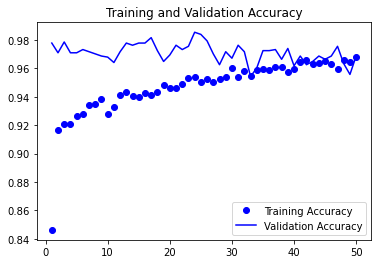

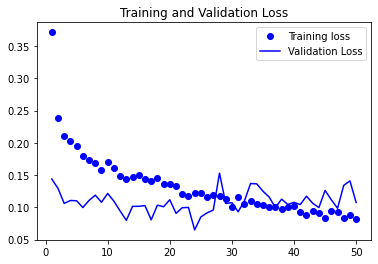

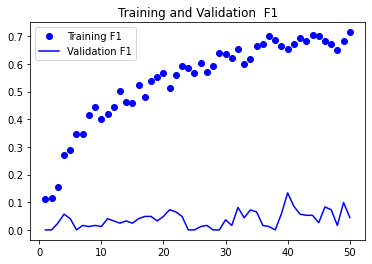

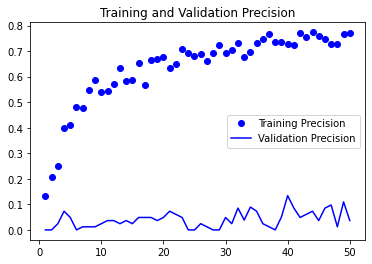

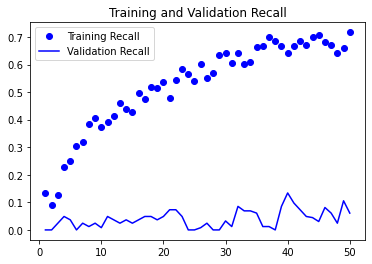

In [21]:
output = open(effnet + str(new_dim)+str(batch)+".txt", "w")
print(history.history, file=output)
output.close()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1_m = history.history['f1_m']
val_f1_m = history.history['val_f1_m']
precision_m = history.history['precision_m']
val_precision_m = history.history['val_precision_m']
recall_m = history.history['recall_m']
val_recall_m = history.history['val_recall_m']


epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig(effnet+str(new_dim)+str(batch)+'accuracy.png')
plt.show()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig(effnet+str(new_dim)+str(batch)+'loss.png')
plt.show()

plt.plot(epochs,f1_m,'bo',label = 'Training F1')
plt.plot(epochs,val_f1_m,'b',label = 'Validation F1')
plt.title('Training and Validation  F1')
plt.legend()
plt.savefig(effnet+str(new_dim)+str(batch)+'F1.png')
plt.show()

plt.plot(epochs,precision_m,'bo',label = 'Training Precision')
plt.plot(epochs,val_precision_m,'b',label = 'Validation Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.savefig(effnet+str(new_dim)+str(batch)+'Precision.png')
plt.show()

plt.plot(epochs,recall_m,'bo',label = 'Training Recall')
plt.plot(epochs,val_recall_m,'b',label = 'Validation Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.savefig(effnet+str(new_dim)+str(batch)+'recall.png')
plt.show()

